In [1]:
import pandas as pd
import numpy as np
import rnaseq_lib as r

from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns
import holoviews as hv
hv.extension('bokeh', logo=False)

In [2]:
# Synapse ID: syn12009613
data_path = '/mnt/data/Objects/tcga_gtex_data.hd5'
exp = pd.read_hdf(data_path, key='exp')
met = pd.read_hdf(data_path, key='met')

In [3]:
df = r.data.add_metadata_to_exp(exp, met)

## CA9 in Kidney
Tumor hypoxia is associated clinically with therapeutic resistance and poor patient outcomes. One feature of tumor hypoxia is activated expression of carbonic anhydrase IX (CA9), a regulator of pH and tumor growth. Disruption of the downstream bicarbonate products can acidify tumor cells and suppress tumor growth [[McIntyre]](http://cancerres.aacrjournals.org/content/76/13/3744.short). Hypoxia also promotes tumour heterogeneity through the epigenetic regulation of CA9 [[Ledaki]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4637295/). CA9 is also a _transmembrane protein_ and is stained for for use as an endogenous marker for investigating hypoxia [[Newbold]](http://www.sciencedirect.com/science/article/pii/S0360301608031799). 

CA9 is part of a family of carbonic anhydrases (zinc metalloenzymes) that catalyze reversible hydration of carbion dioxide to form carbonic acid. _Girentuximab_ (trade name _Rencarex_) is a chimeric IgG1 monoclonal antibody to carbonic anhydrase IX which was granted fast track status and orphan drug designation by the FDA for renal cancer [[Springer]](http://adisinsight.springer.com/drugs/800006571). In January 2017, Telix Pharmaceuticals Limited, an Australian biotechnology company, announced that it had in-licensed Girentuximab for use as a radioimmunoconjugate, iodine (124I) girentuximab, called _Redectane_ [[Arnold]](https://www.biospace.com/article/releases/wilex-ag-release-company-signs-antibody-license-agreement-with-telix-pharma-/).

RNA-seq gene expression data from The Cancer Genome Atlas (TCGA) and the Genotype Tissue Expression Consortium (GTEx) should corroborate literature claims regarding CA9 expression in Renal Cell Carcinomas (RCCs). Once validated, the expression motif of RCCS can be compared to other cancer subtypes to suggest candidates for possible repositioning of CA9-targeted drugs.

In [4]:
h = r.plot.Holoview(df)

In [5]:
kidney = df[df.tissue == 'Kidney']
t, n, g = r.tissues.subset_by_dataset(kidney)

In [6]:
gene = 'CA9'
hists = {}
for subtype in kidney.type.unique():
    hist_group = []
    t, n, g = r.tissues.subset_by_dataset(kidney[kidney.type == subtype])
    for subset, name in zip([t, n, g], ['Tumor', 'Normal', 'GTEx']):
        if len(subset) != 0:
            gene_vals = subset[gene].apply(r.math.l2norm)
            hist = np.histogram(gene_vals, bins=int(np.max(gene_vals) - np.min(gene_vals)))
            hist_group.append(hv.Histogram(hist, label=name, kdims='TPM(log2(x+0.001))'))
    hists[subtype] = hist_group

In [7]:
layouts = []
for group in sorted(hists):
    layouts.append(hv.Overlay(hists[group], label=group))

In [8]:
%%opts Bars (alpha=0.25 hover_alpha=0.75)
r.plot.Holoview(kidney).sample_counts(groupby='type').relabel('Kidney Sample Counts by Subtype')

:Bars   [type,label]   (counts)

In [9]:
%%opts Overlay [width=500 legend_position='top_left']
%%opts Histogram (alpha=0.75) {-axiswise}
hv.Layout(layouts).cols(2)

:Layout
   .Overlay.Kidney_Chromophobe                    :Overlay
      .Histogram.Tumor  :Histogram   [TPM(log2(x+0.001))]   (Frequency)
      .Histogram.Normal :Histogram   [TPM(log2(x+0.001))]   (Frequency)
   .Overlay.Kidney_Cortex                         :Overlay
      .Histogram.GTEx :Histogram   [TPM(log2(x+0.001))]   (Frequency)
   .Overlay.Kidney_Renal_Clear_Cell_Carcinoma     :Overlay
      .Histogram.Tumor  :Histogram   [TPM(log2(x+0.001))]   (Frequency)
      .Histogram.Normal :Histogram   [TPM(log2(x+0.001))]   (Frequency)
   .Overlay.Kidney_Renal_Papillary_Cell_Carcinoma :Overlay
      .Histogram.Tumor  :Histogram   [TPM(log2(x+0.001))]   (Frequency)
      .Histogram.Normal :Histogram   [TPM(log2(x+0.001))]   (Frequency)

#### Combined Kidney Expression

In [10]:
k_tumor = kidney[kidney.tumor == 'yes'].CA9.apply(r.math.l2norm)
k_normal = kidney[kidney.tumor == 'no'].CA9.apply(r.math.l2norm)

  warnings.warn("The 'normed' kwarg is deprecated, and has been "



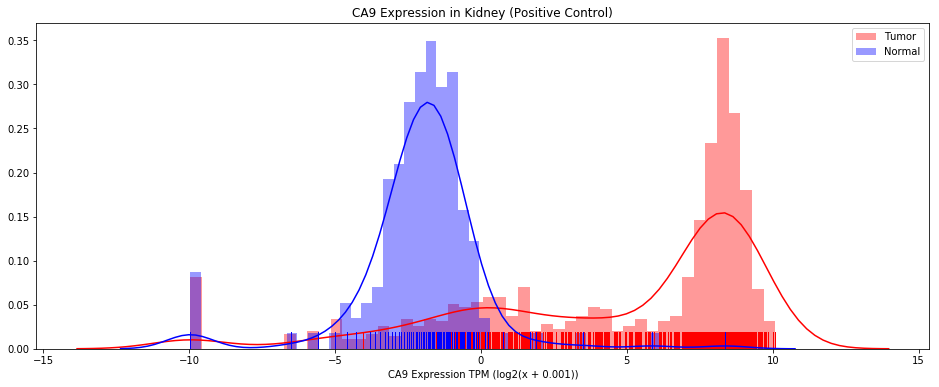

In [11]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.distplot(k_tumor, label='Tumor', ax=ax, kde=True, rug=True, bins=50, color='red')
sns.distplot(k_normal, label='Normal', ax=ax, kde=True, rug=True, bins=50, color='blue')
plt.title('CA9 Expression in Kidney (Positive Control)')
plt.xlabel('CA9 Expression TPM (log2(x + 0.001))')
plt.legend();

#### Differential Expression Distribution

In [12]:
k_tumor = kidney[kidney.tumor == 'yes'].CA9
k_normal_med = kidney[kidney.tumor == 'no'].CA9.median()

In [13]:
kidney_l2fc = r.diff_exp.log2fc(k_tumor, k_normal_med)

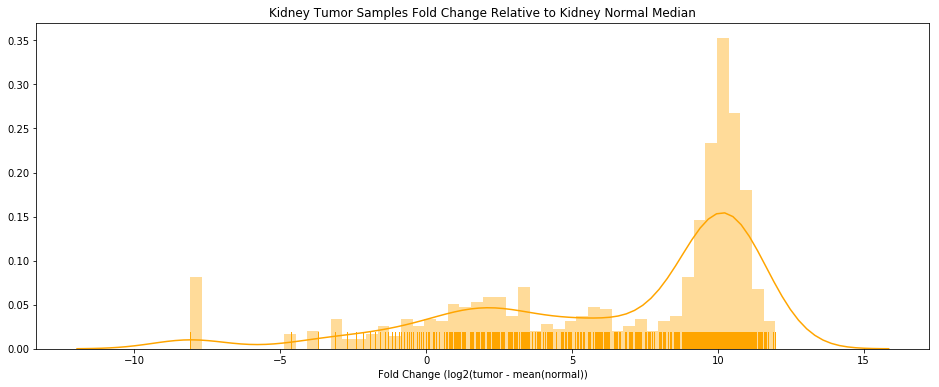

In [14]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.distplot(kidney_l2fc, ax=ax, kde=True, rug=True, bins=50, color='orange')
plt.title('Kidney Tumor Samples Fold Change Relative to Kidney Normal Median')
plt.xlabel('Fold Change (log2(tumor - mean(normal))');

## CA9 Expression Across Tissues

In [15]:
ca9_tumor = df[df.tumor == 'yes'].CA9.apply(r.math.l2norm)
ca9_normal = df[df.tumor == 'no'].CA9.apply(r.math.l2norm)

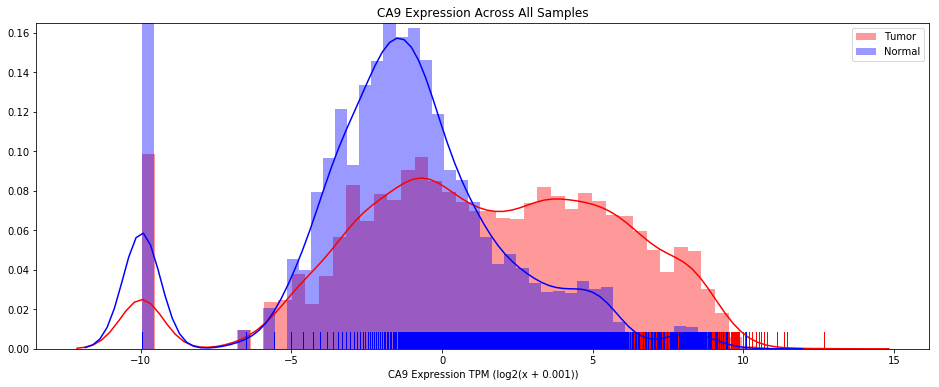

In [16]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.distplot(ca9_tumor, label='Tumor', ax=ax, kde=True, rug=True, bins=50, color='red')
sns.distplot(ca9_normal, label='Normal', ax=ax, kde=True, rug=True, bins=50, color='blue')
plt.title('CA9 Expression Across All Samples')
plt.xlabel('CA9 Expression TPM (log2(x + 0.001))')
plt.legend();

## Identifying Cutoff Via Gaussian Mixture Model

In [17]:
from sklearn import mixture
from scipy.stats import norm

In [18]:
def find_intersection(m1, m2 ,std1, std2):
    m1, m2, std1, std2 = float(m1), float(m2), float(std1), float(std2)
    a =  1.0 /( 2 * std1**2) - 1.0 / ( 2 * std2**2)
    b = m2 / (std2**2) - m1 / (std1**2)
    c = m1**2 / ( 2 * std1**2) - m2**2 / ( 2 * std2**2) - np.log( std2 / std1)
    return np.roots([a,b,c])

Fit 2-component Gaussian mixture model to data

In [19]:
k_tumor = kidney[kidney.tumor == 'yes'].CA9.apply(r.math.l2norm)
# Plot Gaussian Fits
gmm = mixture.GaussianMixture(n_components=2).fit(pd.DataFrame(k_tumor))
m1, m2 = gmm.means_
std1, std2 = gmm.covariances_

Identify intersection

In [49]:
inter = find_intersection(m1, m2, std1, std2)
inter

array([9.56131652, 7.09609276])

In [50]:
cutoff = round(inter[1], 2)

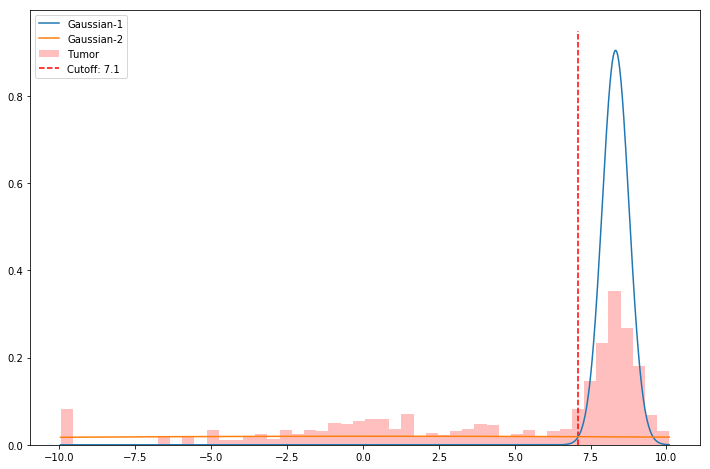

In [52]:
# Plot real data
ax, fig = plt.subplots(figsize=(12, 8))
plt.hist(k_tumor, normed=True, alpha=0.25, bins=50, label='Tumor', color='red')

# Plot Gaussian fits and intersection
x = np.linspace(min(k_tumor), max(k_tumor), len(k_tumor))
plt.plot(x, *norm.pdf(x, m1, std1), label='Gaussian-1')
plt.plot(x, *norm.pdf(x, m2, std2), label='Gaussian-2')
plt.vlines(cutoff, *plt.ylim(), label='Cutoff: {}'.format(cutoff), color='red', linestyles='--')
plt.legend();

# Distribution Fits
Check other distributions in SciPy and identify best fit

## Kolmogorov-Smirnov Tests

In [25]:
ks_tests = r.math.run_ks(k_tumor, r.math.dists.DISTRIBUTIONS)
ks_tests.head(6)

,Name,KS-stat,Pvalue
22,johnsonsb,0.138645,2.664535e-15
33,powerlaw,0.149514,0.000000e+00
29,mielke,0.154811,0.000000e+00
41,vonmises,0.177856,0.000000e+00
6,dweibull,0.183452,0.000000e+00
26,logistic,0.184308,0.000000e+00


Plot top 5 fits

In [27]:
top_5_names = ks_tests.Name[:5].tolist()
top_5_dists = [x for x in r.math.dists.DISTRIBUTIONS if r.math.dists.name_from_dist(x) in top_5_names]

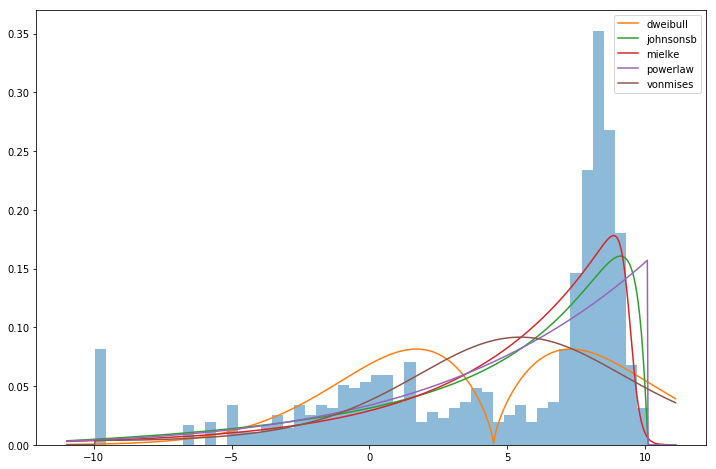

In [32]:
ax, fig = plt.subplots(figsize=(12, 8))
plt.hist(k_tumor, normed=True, alpha=0.5, bins=50)
xmin, xmax = plt.xlim()
for dist in top_5_dists:
    x = np.linspace(xmin, xmax, len(k_tumor))
    plt.plot(x, dist.pdf(x, *dist.fit(k_tumor)), label=r.math.dists.name_from_dist(dist))
    plt.legend()

### Include Zero Counts

In [35]:
ks_tests = r.math.run_ks(k_tumor, r.math.DISTRIBUTIONS)
ks_tests.head(6)

,Name,KS-stat,Pvalue
22,johnsonsb,0.138645,2.664535e-15
33,powerlaw,0.149514,0.000000e+00
29,mielke,0.154811,0.000000e+00
41,vonmises,0.177856,0.000000e+00
6,dweibull,0.183452,0.000000e+00
26,logistic,0.184308,0.000000e+00


In [ ]:
top_5_names = ks_tests.Name[:5].tolist()
top_5_dists = [x for x in DISTRIBUTIONS if name(x) in top_5_names]
ax, fig = plt.subplots(figsize=(12, 8))
plt.hist(k_tumor, normed=True, alpha=0.5, bins=50)
xmin, xmax = plt.xlim()
for dist in top_5_dists:
    x = np.linspace(xmin, xmax)
    plt.plot(x, dist.pdf(x, *dist.fit(k_tumor)), label=r.math.dists.name_from_dist(dist))
    plt.legend()

The Mielke distribution does a great job of modeling our tumor distribution

## Example with Tumor and Normal

In [40]:
from scipy import stats

In [41]:
k_tumor = kidney[kidney.tumor == 'yes'].CA9.apply(r.math.l2norm)
k_normal = kidney[kidney.tumor == 'no'].CA9.apply(r.math.l2norm)

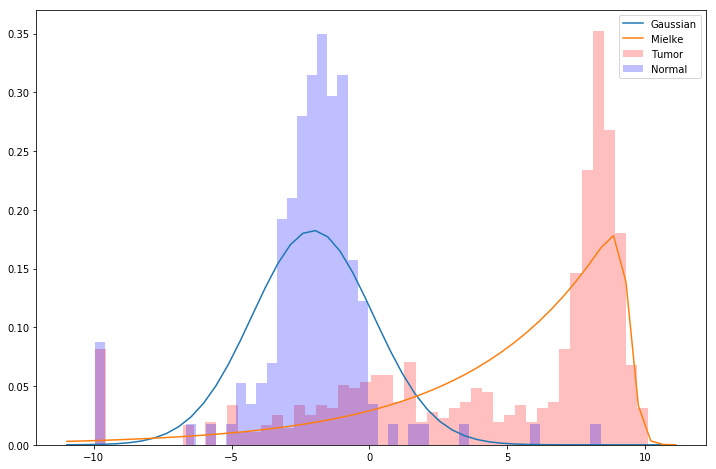

In [42]:
ax, fig = plt.subplots(figsize=(12, 8))
plt.hist(k_tumor, normed=True, alpha=0.25, bins=50, label='Tumor', color='red')
plt.hist(k_normal, normed=True, alpha=0.25, bins=50, label='Normal', color='blue')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax)
# Fit Gaussian to normal and plot
plt.plot(x, norm.pdf(x, *stats.norm.fit(k_normal)), label='Gaussian')
# Fit Mielke distribution to tumor and plot
plt.plot(x, stats.mielke.pdf(x, *stats.mielke.fit(k_tumor)), label='Mielke')
plt.legend();

## All Fits

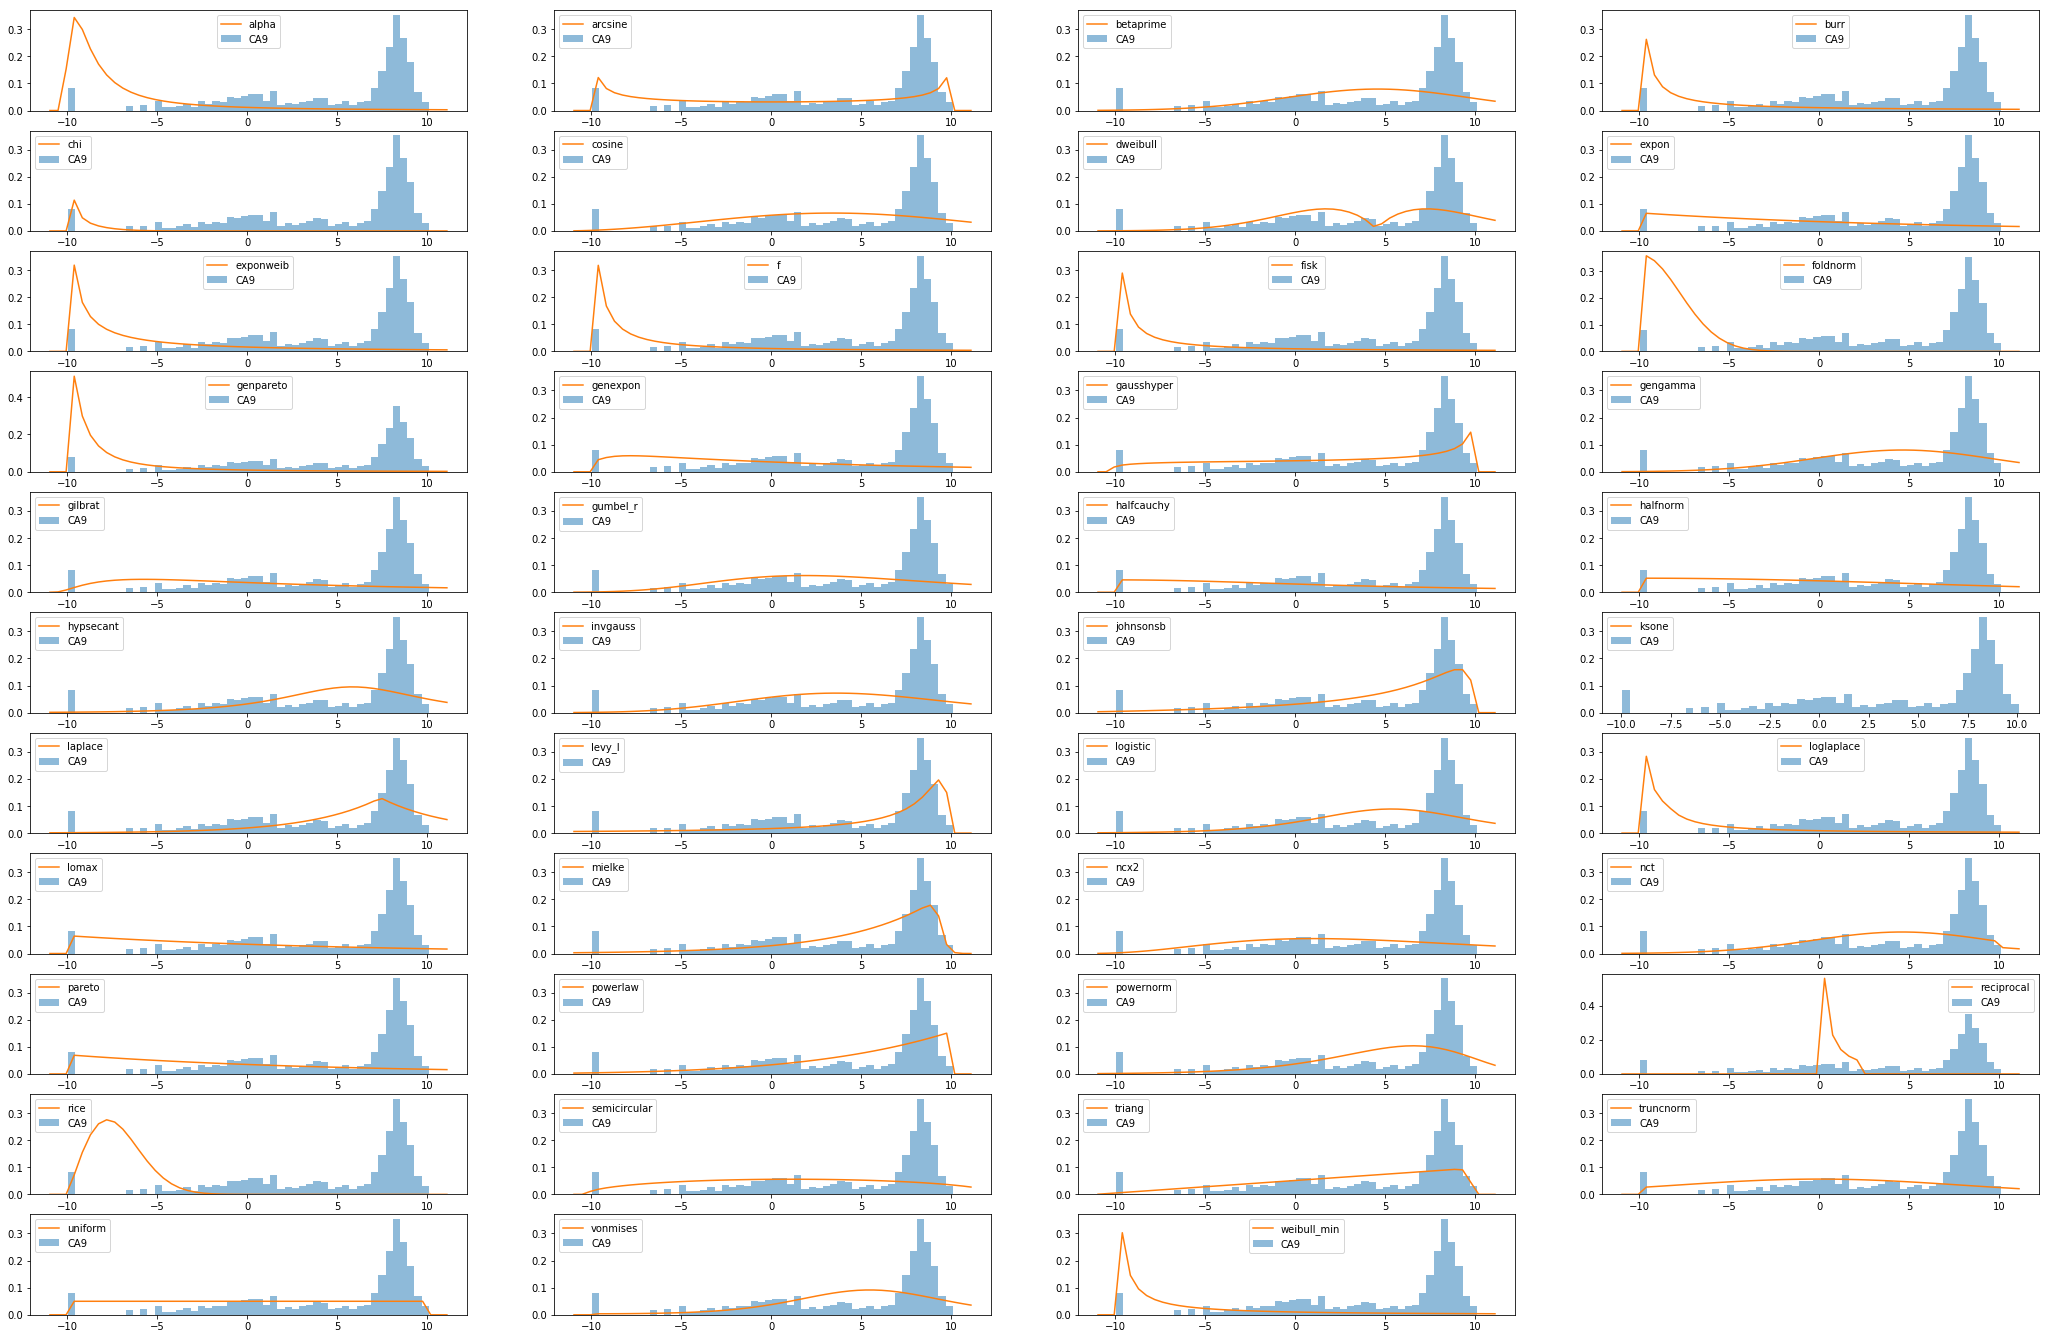

In [46]:
nrows, ncols = 11, 4
fig = plt.figure(figsize=(36, 24))
for i, dist in enumerate(r.math.dists.DISTRIBUTIONS):
    ax = fig.add_subplot(nrows, ncols, i+1)
    ax.hist(k_tumor, normed=True, alpha=0.5, bins=50)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax)
    ax.plot(x, dist.pdf(x, *dist.fit(k_tumor)), label=r.math.dists.name_from_dist(dist))
    plt.legend()
plt.show()